# Pretrained Transformers as Universal Computation Engines Demo

This is a demo notebook illustrating creating a Frozen Pretrained Transformer (FPT) and training on the Bit XOR task, which converges within a couple minutes.

arXiv: https://arxiv.org/pdf/2103.05247.pdf

Github: https://github.com/kzl/universal-computation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from transformers.models.gpt2.modeling_gpt2 import GPT2Model

## Creating the dataset

For this demo, we'll look at calculating the elementwise XOR between two randomly generated bitstrings.
If you want to play more with the model, feel free to try larger $n$, although it will take longer to train.

In [2]:
def generate_example(n):
    bits = np.random.randint(low=0, high=2, size=(2, n))
    xor = np.logical_xor(bits[0], bits[1]).astype(np.long)
    return bits.reshape((2*n)), xor

In [3]:
n = 5
bits, xor = generate_example(n)

print('  String 1:', bits[:n])
print('  String 2:', bits[n:])
print('Output XOR:', xor)

  String 1: [0 0 1 1 0]
  String 2: [0 0 1 0 0]
Output XOR: [0 0 0 1 0]


## Creating the frozen pretrained transformer

We simply wrap a pretrained GPT-2 model with linear input and output layers, then freeze the weights of the self-attention and feedforward layers.
You can also see what happens using a randomly initialized model instead.

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [5]:
gpt2 = GPT2Model.from_pretrained('gpt2')  # loads a pretrained GPT-2 base model
in_layer = nn.Embedding(2, 768)           # map bit to GPT-2 embedding dim of 768
out_layer = nn.Linear(768, 2)             # predict logits

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
for name, param in gpt2.named_parameters():
    # freeze all parameters except the layernorm and positional embeddings
    if 'ln' in name or 'wpe' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

## Training loop

We train the model with stochastic gradient descent on the Bit XOR task.
The model should converge within 5000 samples.

In [7]:
params = list(gpt2.parameters()) + list(in_layer.parameters()) + list(out_layer.parameters())
optimizer = torch.optim.Adam(params)
loss_fn = nn.CrossEntropyLoss()

In [8]:
for layer in (gpt2, in_layer, out_layer):
    layer.to(device=device)
    layer.train()

In [9]:
accuracies = [0]
while sum(accuracies[-50:]) / len(accuracies[-50:]) < .99:
    x, y = generate_example(n)
    x = torch.from_numpy(x).to(device=device, dtype=torch.long)
    y = torch.from_numpy(y).to(device=device, dtype=torch.long)
    
    embeddings = in_layer(x.reshape(1, -1))
    hidden_state = gpt2(inputs_embeds=embeddings).last_hidden_state[:,n:]
    logits = out_layer(hidden_state)[0]
    
    loss = loss_fn(logits, y)
    accuracies.append((logits.argmax(dim=-1) == y).float().mean().item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if len(accuracies) % 500 == 0:
        accuracy = sum(accuracies[-50:]) / len(accuracies[-50:])
        print(f'Samples: {len(accuracies)}, Accuracy: {accuracy}')

print(f'Final accuracy: {sum(accuracies[-50:]) / len(accuracies[-50:])}')

Samples: 500, Accuracy: 0.6320000129938126
Samples: 1000, Accuracy: 0.600000016093254
Samples: 1500, Accuracy: 0.6560000130534172
Samples: 2000, Accuracy: 0.7320000123977661
Samples: 2500, Accuracy: 0.6400000116229058
Samples: 3000, Accuracy: 0.6960000142455101
Samples: 3500, Accuracy: 0.7640000116825104
Samples: 4000, Accuracy: 0.7520000123977661
Samples: 4500, Accuracy: 0.7560000121593475
Samples: 5000, Accuracy: 0.8280000087618827
Samples: 5500, Accuracy: 0.9000000059604645
Samples: 6000, Accuracy: 0.9440000027418136
Samples: 6500, Accuracy: 0.9520000028610229
Final accuracy: 0.9920000004768371


## Visualizing attention map

We can visualize the attention map of the first layer: the model learns to attend to the relevant bits for each element in the XOR operation.
Note the two consistent diagonal lines for output tokens 5-9 across samples, denoting each position of either string (the pattern is stronger if the model is allowed to train longer or evaluated on more samples).

In [10]:
for layer in (gpt2, in_layer, out_layer):
    layer.eval()

In [11]:
bits, xor = generate_example(n)

with torch.no_grad():
    x = torch.from_numpy(bits).to(device=device, dtype=torch.long)
    
    embeddings = in_layer(x)
    transformer_outputs = gpt2(
        inputs_embeds=embeddings,
        return_dict=True,
        output_attentions=True,
    )
    logits = out_layer(transformer_outputs.last_hidden_state[n:])
    predictions = logits.argmax(dim=-1).cpu().numpy()

print('  String 1:', bits[:n])
print('  String 2:', bits[n:])
print('Prediction:', predictions)
print('Output XOR:', xor)

  String 1: [0 1 1 0 0]
  String 2: [1 1 1 1 1]
Prediction: [1 0 0 1 1]
Output XOR: [1 0 0 1 1]


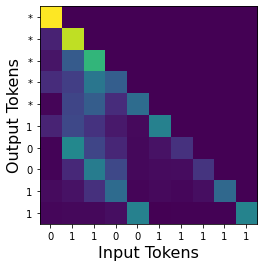

In [12]:
attentions = transformer_outputs.attentions[0][0]  # first layer, first in batch
mean_attentions = attentions.mean(dim=0)           # take the mean over heads
mean_attentions = mean_attentions.cpu().numpy()

plt.xlabel('Input Tokens', size=16)
plt.xticks(range(10), bits)
plt.ylabel('Output Tokens', size=16)
plt.yticks(range(10), ['*'] * 5 + list(predictions))

plt.imshow(mean_attentions)

## Sanity check

As a sanity check, we can see that the model could solve this task without needing to finetune the self-attention layers! The XOR was computed using only the connections already present in GPT-2.

In [13]:
fresh_gpt2 = GPT2Model.from_pretrained('gpt2')

gpt2.to(device='cpu')
gpt2_state_dict = gpt2.state_dict()
for name, param in fresh_gpt2.named_parameters():
    if 'attn' in name or 'mlp' in name:
        new_param = gpt2_state_dict[name]
        if torch.abs(param.data - new_param.data).sum() > 1e-8:
            print(f'{name} was modified')
        else:
            print(f'{name} is unchanged')

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


h.0.attn.c_attn.weight is unchanged
h.0.attn.c_attn.bias is unchanged
h.0.attn.c_proj.weight is unchanged
h.0.attn.c_proj.bias is unchanged
h.0.mlp.c_fc.weight is unchanged
h.0.mlp.c_fc.bias is unchanged
h.0.mlp.c_proj.weight is unchanged
h.0.mlp.c_proj.bias is unchanged
h.1.attn.c_attn.weight is unchanged
h.1.attn.c_attn.bias is unchanged
h.1.attn.c_proj.weight is unchanged
h.1.attn.c_proj.bias is unchanged
h.1.mlp.c_fc.weight is unchanged
h.1.mlp.c_fc.bias is unchanged
h.1.mlp.c_proj.weight is unchanged
h.1.mlp.c_proj.bias is unchanged
h.2.attn.c_attn.weight is unchanged
h.2.attn.c_attn.bias is unchanged
h.2.attn.c_proj.weight is unchanged
h.2.attn.c_proj.bias is unchanged
h.2.mlp.c_fc.weight is unchanged
h.2.mlp.c_fc.bias is unchanged
h.2.mlp.c_proj.weight is unchanged
h.2.mlp.c_proj.bias is unchanged
h.3.attn.c_attn.weight is unchanged
h.3.attn.c_attn.bias is unchanged
h.3.attn.c_proj.weight is unchanged
h.3.attn.c_proj.bias is unchanged
h.3.mlp.c_fc.weight is unchanged
h.3.mlp.c_f